## Project: Build a Traffic Sign Recognition Classifier

Author : Mouad HADJI, January 2nd, 2018.

In this project, I will explain how to use deep neural networks and convolutional neural networks to classify traffic signs. Specifically, you'll train a model to classify traffic signs from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

---
## 1. Import packages

In this section, we import the packages we will use throughout the project. If there is the need for other packages, we will load them later.

In [1]:
import os
import sys
import glob
import pickle
import cv2
import random
from scipy import ndimage
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 2. Load The Data

We first load the 3 datasets (train, validation, test) that will allow us to train, measure the performance and evaluate our classifier. Since we will try training on both local machine and a GPU instance, we use a clean notation of paths.

In [2]:
project_path = os.path.join(os.environ['HOME'], "sdcnd/sdcnd_traffic_sign_classifier")
data_path = os.path.join(project_path, "traffic-signs-data")
model_path = os.path.join(project_path, "models")
new_images_path = os.path.join(project_path, "images")

In [3]:
training_file = os.path.join(data_path, "train.p")
validation_file= os.path.join(data_path, "valid.p")
testing_file = os.path.join(data_path, "test.p")

In [4]:
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [5]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## 3. Data Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

In [6]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)

image_shape = train['features'][0].shape

n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


`sign_names` contains the names of the names. Let's load it and check out the label names

In [7]:
sign_names = pd.read_csv(os.path.join(project_path, "signnames.csv"))
sign_names.set_index("ClassId", inplace=True)
sign_dict = sign_names.SignName.to_dict()

In [8]:
sign_dict

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

### Visualize the dataset :

In [9]:
def show_images(images, n_row=2, n_col=3, labels=None, cmap=None, save=False, filename=''):

    fig, ax = plt.subplots(n_row, n_col, figsize=(15, 6))
    ax = ax.ravel()
    n_images = n_row*n_col
    
    for i, image in enumerate(images):
        plt.subplot(n_row, n_col, i+1)
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
        plt.title(labels[i])    
    if save:
        plt.savefig(os.path.join(new_images_path, filename + '.png'))
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

Let's randomly display 6 traffic signs with their labels. We will keep the same ones to show the effect of the data transformation we implement later in this notebook

Shape of demo images :  (32, 32, 3)


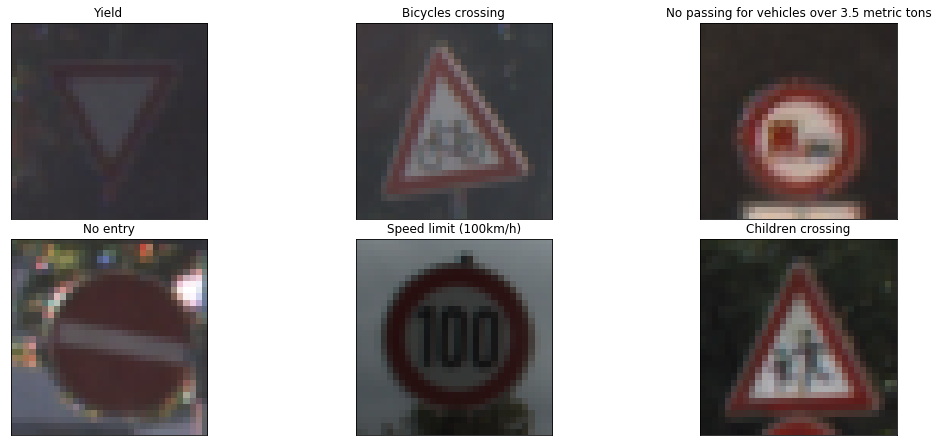

In [10]:
demo_index = list(np.random.randint(0, len(X_train) + 1, 6))
demo_images = [X_train[i] for i in demo_index]
demo_labels = [sign_dict[y_train[i]] for i in demo_index]
print('Shape of demo images : ', demo_images[0].shape)
show_images(demo_images, labels=demo_labels, save=True, filename='demo_original')

#### Plotting the distribution of the classes

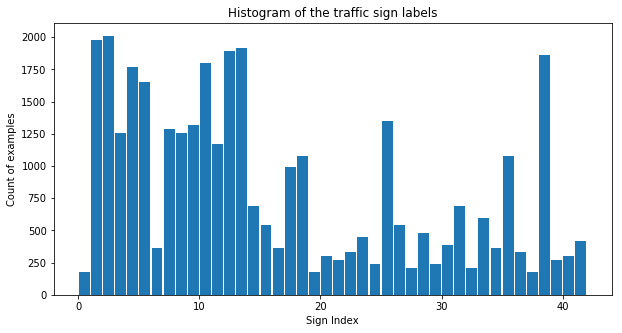

In [11]:
plt.figure(figsize=(10,5))
plt.xlabel("Sign Index")
plt.ylabel("Count of examples")
plt.hist(y_train, bins=list(range(n_classes)), rwidth=0.9)
plt.title("Histogram of the traffic sign labels")
plt.savefig(os.path.join(new_images_path,  'original_dataset_dist.png'))
plt.show()

We can note that the dataset is not balanced at all. This is not optimal but hopefully we can achieve great performance with this imbalanced dataset.

----

## 4. Design and Test a Model Architecture

Let us now design and implement a deep learning model that learns to recognize traffic signs. We will implement this in different steps :

- First, we will create a pipeline for **pre-processing** the images (normalize, grayscale, etc.)
- Besides, we will **enhance our dataset** by implementing dataset augmentation
- Then, we will proceed to the **design** of our deep learning model by taking inspiration in the LeNet architecture
- Eventually, we will **measure the performance** of our model

### 4.i. Pre-process the images

In this step, we want to pre-process the image data. They are several transformation we can implement : normalization, grayscale, etc. We will implement several of them below.

In [12]:
def normalize(img):
    return (img - np.mean(img)) / np.std(img)

In [13]:
def gray_scale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [14]:
def pre_process_img(img):
    img = gray_scale(img)
    img = normalize(img)
    return img

In [15]:
demo_images_preprocessed = [pre_process_img(img) for img in demo_images]

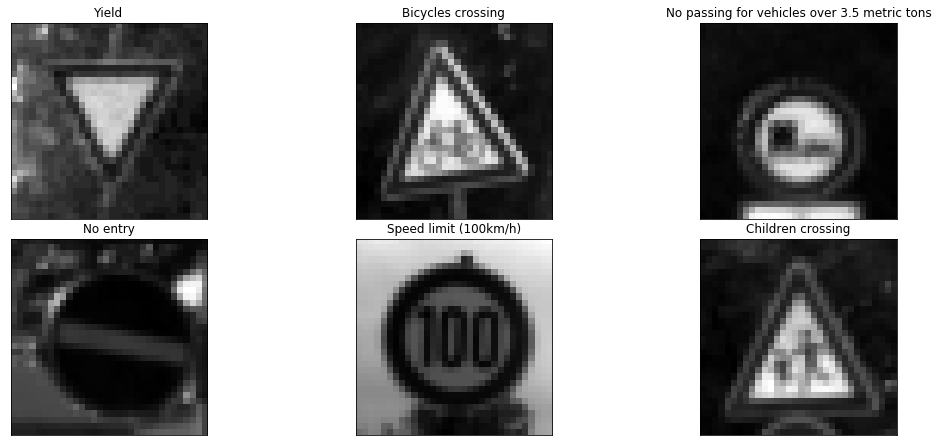

In [16]:
show_images(demo_images_preprocessed, labels=demo_labels, save=True, filename='demo_preprocessed')

### 4.iI. Augment the dataset

Because the dataset is imbalanced, I decided here to augment the dataset by implementing several image transformations that will allow to enhance our dataset : 

- translation
- rescaling
- rotation
- blurring

In [17]:
class AugmentationEffect:

    def translate(self, img):
        x, y, z = img.shape
        max_px = 0.2
        dx = np.random.uniform(-max_px * x, max_px * x)
        dy = np.random.uniform(-max_px * y, max_px * y)
        translated_matrix = np.float32([[1, 0, dx], [0, 1, dy]])
        translated_img = cv2.warpAffine(img, translated_matrix, (x, y))
        return translated_img
    
    def scale(self, img):   
        x, y, z = img.shape
        max_scale = np.random.randint(-2,2)
        # ending locations
        pts1 = np.float32([[max_scale, max_scale], [x - max_scale, max_scale], [max_scale, y - max_scale], [x - max_scale, y - max_scale]])
        # starting locations (4 corners)
        pts2 = np.float32([[0,0],[x,0],[0,y],[x,y]])
        M = cv2.getPerspectiveTransform(pts1,pts2)
        scaled_img = cv2.warpPerspective(img,M,(x,y))
        return scaled_img

    def rotate(self, img):
        x, y, z = img.shape
        angle = np.random.uniform(-60, 60)
        rotation_center = (x / 2, y / 2)
        rotation_matrix = cv2.getRotationMatrix2D(rotation_center, angle, 1)
        rotated_img = cv2.warpAffine(img, rotation_matrix, (x, y))
        return rotated_img

    def blur(self, img):
        r_int = np.random.randint(0, 2)
        odd_size = 2 * r_int + 1
        return cv2.GaussianBlur(img, (odd_size, odd_size), 0)
    
    def run_random(self, img):
        random_choice = np.random.randint(4)
        function_map = dict(zip(range(4),[self.translate, self.scale, self.rotate, self.blur]))
        return function_map[random_choice](img)

In [18]:
AE = AugmentationEffect()

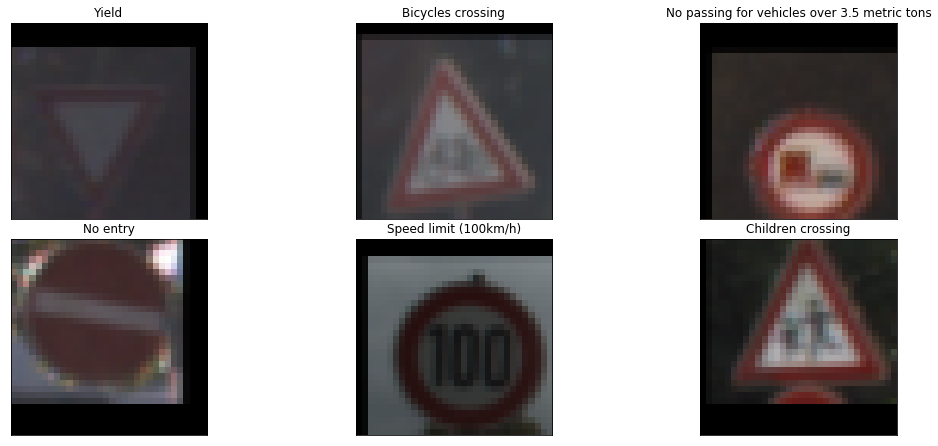

In [19]:
demo_images_translated = [AE.translate(img) for img in demo_images]
show_images(demo_images_translated, labels=demo_labels, save=True, filename='demo_translated')

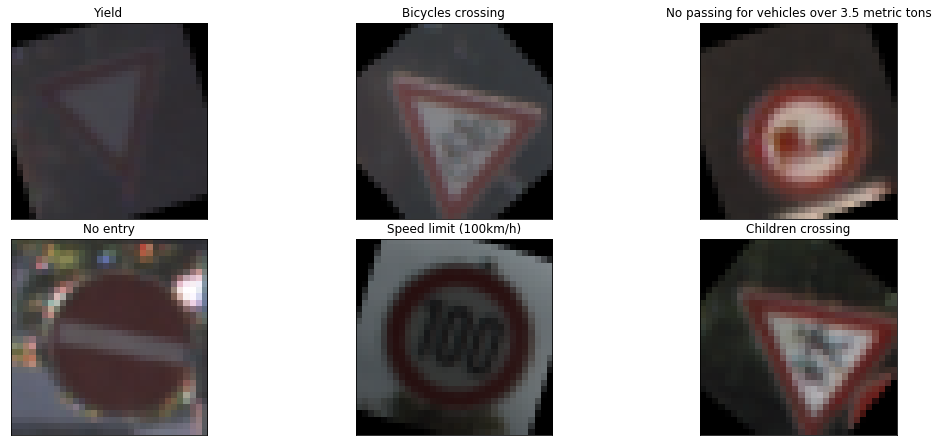

In [20]:
demo_images_rotated = [AE.rotate(img) for img in demo_images]
show_images(demo_images_rotated, labels=demo_labels, save=True, filename='demo_rotated')

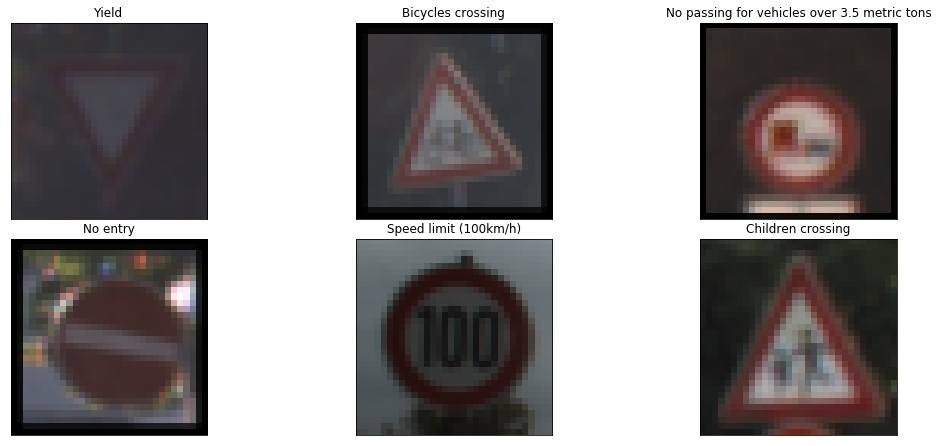

In [21]:
demo_images_scaled = [AE.scale(img) for img in demo_images]
show_images(demo_images_scaled, labels=demo_labels, save=True, filename='demo_rescaled')

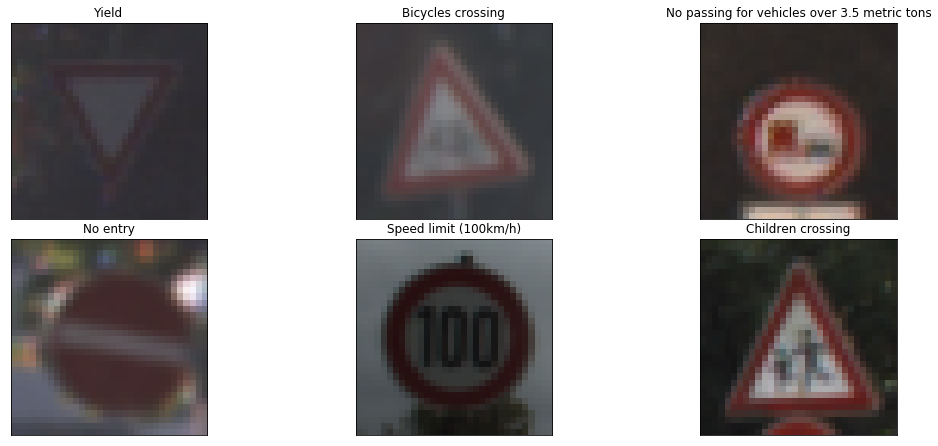

In [22]:
demo_images_blurred = [AE.blur(img) for img in demo_images]
show_images(demo_images_blurred, labels=demo_labels, save=True, filename='demo_blurred')

Now that we introduced multiple transformations that we can use to augment our dataset, let us use them to balance our dataset. Let us bring the number of training examples to 1000 per class.

In [23]:
class AugmentDataset:
    
    def __init__(self, data_path): 
        self.data_path = data_path
        self.ae = AugmentationEffect()   

    def load_data(self):
        training_file = os.path.join(self.data_path, "train.p")
        with open(training_file, 'rb') as f:
            train = pickle.load(f)
        return train
    
    def save_data(self):
        output_path = os.path.join(self.data_path, "train_new.p")
        with open(output_path, 'wb') as f:
            pickle.dump({"features":self.X_train_new, "labels":self.y_train_new} , f)
        return True
    
    def run(self):
        
        train_data = self.load_data()
        
        self.X_train = train_data['features']
        self.y_train = train_data['labels']
        
        n_labels = len(set(self.y_train))
        ts, imgs_per_sign = np.unique(self.y_train, return_counts=True)
        avg_image_per_class = round(np.mean(imgs_per_sign))
        
        X_train_new = []
        y_train_new = []
        
        for label in tqdm(range(n_labels)):
            img_label_idx = np.where(self.y_train == label)[0]
            count_examples = len(img_label_idx)
            count_to_add = np.int(avg_image_per_class - count_examples)
            
            # adding all existing entities
            for i in range(count_examples):
                X_train_new.append(X_train[img_label_idx[i]])
                y_train_new.append(label)
            
            # adding if missing
            if count_to_add > 0 :
                selected_idx = np.random.choice(img_label_idx, count_to_add)
                added_images = np.array([self.ae.run_random(img) for img in list(X_train[selected_idx])])
                for i in range(len(added_images)):
                    X_train_new.append(added_images[i])
                    y_train_new.append(label)
            
        self.X_train_new = np.array(X_train_new)
        self.y_train_new = np.array(y_train_new)
        
        self.save_data()

In [24]:
AD = AugmentDataset(data_path)
AD.run()

100%|██████████| 43/43 [00:00<00:00, 92.53it/s] 


In [25]:
training_file_new = os.path.join(data_path, "train_new.p")

with open(training_file_new, mode='rb') as f:
    train_new = pickle.load(f)
    
X_train = train_new["features"]
y_train = train_new["labels"]

In [26]:
print("New dataset size : {}".format(len(X_train)))

New dataset size : 46714


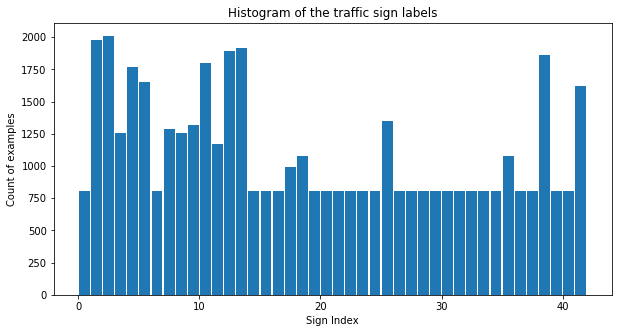

In [27]:
plt.figure(figsize=(10,5))
plt.xlabel("Sign Index")
plt.ylabel("Count of examples")
plt.hist(y_train, bins=list(range(n_classes)), rwidth=0.9)
plt.title("Histogram of the traffic sign labels")
plt.savefig(os.path.join(new_images_path,  'augmented_dataset_dist.png'))
plt.show()

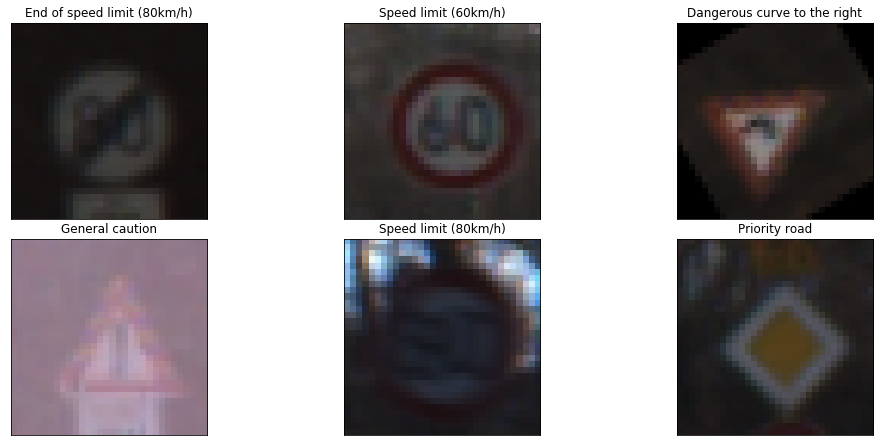

In [28]:
demo_index = list(np.random.randint(0, len(X_train) + 1, 6))
demo_images = [X_train[i] for i in demo_index]
demo_labels = [sign_dict[y_train[i]] for i in demo_index]
show_images(demo_images, labels=demo_labels, save=True, filename='demo_random_augmented')

Here, we do the basic pre-processing we entended to do with the training data.

In [29]:
from sklearn.utils import shuffle

In [30]:
X_train, y_train = shuffle(X_train, y_train)

In [31]:
X_train = np.array([pre_process_img(img) for img in X_train])
X_valid = np.array([pre_process_img(img) for img in X_valid])
X_test = np.array([pre_process_img(img) for img in X_test])

In [32]:
shapes = [x.shape for x in X_train]
pd.Series(shapes).value_counts()

(32, 32)    46714
dtype: int64

In [33]:
X_train = X_train[:,:,:,np.newaxis]
X_valid = X_valid[:,:,:,np.newaxis]
X_test = X_test[:,:,:,np.newaxis]

### 4.iii. Model Architecture

In this example, we will implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture. We will describe below all the details of the model architecture.

#### Inputs

The number of color channels here is `3`. If we decide to grayscale, the number of channels will be reduced to `1`. The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels.

#### Outputs

The number of classes to label is 43. Hence the length of Logits layer will be 43.

#### Architecture :  5 Layers (CONV-POOL, CONV-POOL, FC, FC, FC)

**Layer 1:**
**Convolutinal.** The output shape should be 28x28x6.
**Activation.** RELU.
**Pooling.** The output shape should be 14x14x6.

**Layer 2:**
**Convolutional.** The output shape should be 10x10x16.
**Activation.** RELU.
**Pooling.** The output shape should be 5x5x16.
**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

**Layer 3:**
**Fully Connected.** This should have 120 outputs.
**Activation.** RELU.
**Dropout.** 90% pass.

**Layer 4:**
**Fully Connected.** This should have 84 outputs.
**Activation.** RELU.
**Dropout.** 90% pass.

**Layer 5:**
**Fully Connected (Logits).** This should have 43 outputs.

In [34]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

Let's define here the basic **CONV** and **POOL** layers that we will use multiple times : 

In [35]:
def conv2d(x, weights, biases, strides=1, padding='VALID'):
    conv = tf.nn.conv2d(x, weights, strides=[1, strides, strides, 1], padding=padding)
    conv = tf.add(conv, biases)
    return conv

def maxpool2d(x, k=2, padding='VALID'):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding=padding)

In [36]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    ########################## LAYER 1
    
    w_1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    b_1 = tf.Variable(tf.zeros(6))
    
    conv1 = conv2d(x, w_1, b_1, strides=1) # Convolution. Input = 32x32x3. Output = 28x28x6.
    conv1 = tf.nn.relu(conv1) # Activation
    conv1 = maxpool2d(conv1, k=2) # Pooling. Input = 28x28x6. Output = 14x14x6.
    
    ########################## LAYER 2
    
    w_2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    b_2 = tf.Variable(tf.zeros(16))
    
    conv2 = conv2d(conv1, w_2, b_2, strides=1) # Convolution. Input = 14x14x16. Output = 10x10x16.
    conv2 = tf.nn.relu(conv2) # Activation
    conv2 = maxpool2d(conv2, k=2) # Pooling. Input = 10x10x16. Output = 5x5x16.

    fc0   = flatten(conv2) # Flatten. Input = 5x5x16. Output = 400.
    
    ########################## LAYER 3
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b # Fully Connected. Input = 400. Output = 120.
    fc1    = tf.nn.relu(fc1) # Activation.
    fc1    = tf.nn.dropout(fc1, keep_prob) ## Dropout
    
    ########################## LAYER 4

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b # Fully Connected. Input = 120. Output = 84.
    fc2    = tf.nn.relu(fc2) # Activation.
    fc2    = tf.nn.dropout(fc2, keep_prob) ## Dropout
    
    ########################## LAYER 5

    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    
    logits = tf.matmul(fc2, fc3_W) + fc3_b # Fully Connected. Input = 84. Output = 43.
    
    return logits

### 4.iii. Training and Evaluation Pipelines

In this section, we define the inputs (features = images) and outputs (labels = categories) for the tensorflow model :
    
- `x` is a placeholder for a batch of input images.
- `y` is a placeholder for a batch of output labels.

In [37]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

The `RATE`, `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

In [38]:
RATE = 0.001
EPOCHS = 25
BATCH_SIZE = 128

In [39]:
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = RATE)
training_operation = optimizer.minimize(loss_operation)

For the evaluation, we will use the following function to compute the acuuracy of the trained model :

In [40]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [41]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.9})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### 4.iv. Train and Validate the Model

This section will run the training data through the training pipeline to train the model. It follows multiple steps :

- Before each epoch, shuffle the training set.
- After each epoch, measure the loss and accuracy of the validation set.
- Save the model after training.

In [42]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    
    ## store tore the performance for plots
    training_acc_hist = []
    validation_acc_hist = []
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.6})
        
        ## compute the accuracy for the training/ validation sets
        training_accuracy = sess.run(accuracy_operation, feed_dict={x: X_train, y: y_train, keep_prob: 1.0})
        validation_accuracy = sess.run(accuracy_operation, feed_dict={x: X_valid, y: y_valid, keep_prob: 1.0})
        
        ## store history for plotting curves
        training_acc_hist.append(training_accuracy)
        validation_acc_hist.append(validation_accuracy)
        
        validation_predictions = tf.argmax(logits, 1)
        validation_logits = logits
        
        print("EPOCH {} ".format(i+1),
              #": Training Accuracy = {:.3f}".format(training_accuracy),
              ": Validation Accuracy = {:.3f}".format(validation_accuracy)
             )
        
    saver.save(sess, './lenet_model')
    print("Model saved")

Training...

EPOCH 1  : Validation Accuracy = 0.814
EPOCH 2  : Validation Accuracy = 0.903
EPOCH 3  : Validation Accuracy = 0.919
EPOCH 4  : Validation Accuracy = 0.928
EPOCH 5  : Validation Accuracy = 0.932
EPOCH 6  : Validation Accuracy = 0.946
EPOCH 7  : Validation Accuracy = 0.929
EPOCH 8  : Validation Accuracy = 0.941
EPOCH 9  : Validation Accuracy = 0.948
EPOCH 10  : Validation Accuracy = 0.949
EPOCH 11  : Validation Accuracy = 0.943
EPOCH 12  : Validation Accuracy = 0.944
EPOCH 13  : Validation Accuracy = 0.947
EPOCH 14  : Validation Accuracy = 0.946
EPOCH 15  : Validation Accuracy = 0.938
EPOCH 16  : Validation Accuracy = 0.948
EPOCH 17  : Validation Accuracy = 0.947
EPOCH 18  : Validation Accuracy = 0.948
EPOCH 19  : Validation Accuracy = 0.948
EPOCH 20  : Validation Accuracy = 0.956
EPOCH 21  : Validation Accuracy = 0.952
EPOCH 22  : Validation Accuracy = 0.952
EPOCH 23  : Validation Accuracy = 0.947
EPOCH 24  : Validation Accuracy = 0.952
EPOCH 25  : Validation Accuracy = 0.

#### Validation of the model

Let's plot the **training** and **accuracy** history after each epoch.

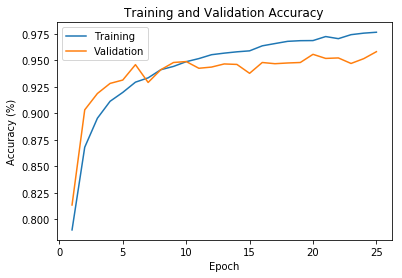

In [43]:
plt.plot(range(1, EPOCHS+1), training_acc_hist, label = "Training")
plt.plot(range(1, EPOCHS+1), validation_acc_hist, label = 'Validation')
plt.title("Training and Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.savefig(os.path.join(new_images_path,  'train_valid_acc_epoch.png'))
plt.show()

We can see that the "dropout layers" allow us to prevent over-fitting (indeed, the accuracies do not to diverge too much until the 15th epoch)

### 4.v. Evaluate the Model (using test set)

In [44]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.933


---

## 5. Test our Model on New Images

We can know check the performance of our model on random pictures of German traffic signs downloaded from the Internet.

### 5.i. Load and Output the Images

In [45]:
def read_image(image_path):
    img = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_shape[0], image_shape[1]))
    return img

In [46]:
new_labels = [11, 1, 12, 14, 25, 33]

In [47]:
new_images = [read_image(os.path.join(new_images_path, 'test_image_' + str(i + 1) + '.jpg')) for i in list(range(6))]

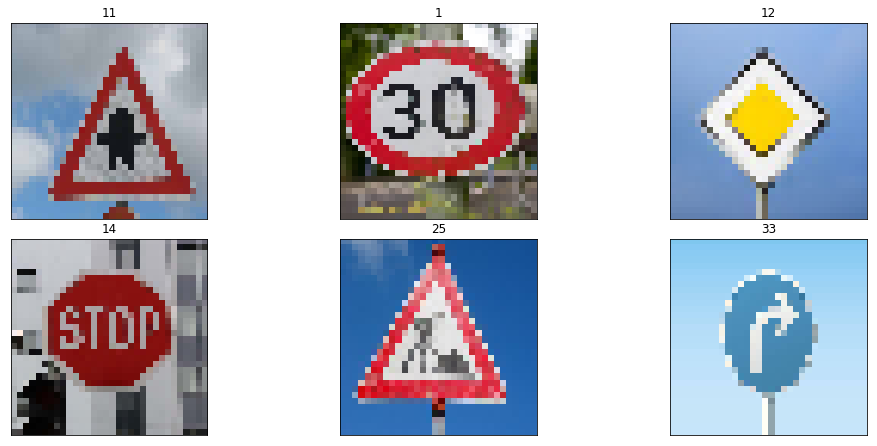

In [48]:
show_images(new_images, labels=new_labels, save=True, filename='demo_new_images')

### 5.ii. Predict the Sign Type for Each Image

In [49]:
new_images_processed = [pre_process_img(img) for img in new_images]
X_new_images = np.array(new_images_processed)[:,:,:, np.newaxis]

In [50]:
X_new_images[0].shape

(32, 32, 1)

In [51]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    new_img_accuracy = evaluate(X_new_images, new_labels)
    print("New Image Accuracy = {:.3f}".format(new_img_accuracy))

New Image Accuracy = 0.333


The accuracy on the new images is quite good. Let's explore the probabilities in more details.

### 5.iii. Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, let's print out the model's softmax probabilities to show the **certainty** of the model's predictions (we will limit the output to the top 5 probabilities for each image). For this purpose, we will use the  [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) function.

In [52]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    logits = sess.run(tf.nn.softmax(logits), feed_dict={x: X_new_images, y: new_labels, keep_prob: 0.9})
    top_K_values, top_K_indices = sess.run(tf.nn.top_k(logits, k=5))

In [53]:
top_K_indices = [list(item) for item in list(top_K_indices)]
top_K_labels = [list([sign_dict[idx] for idx in list(item)]) for item in list(top_K_indices)]
top_K_values = [list(item) for item in list(top_K_values)]

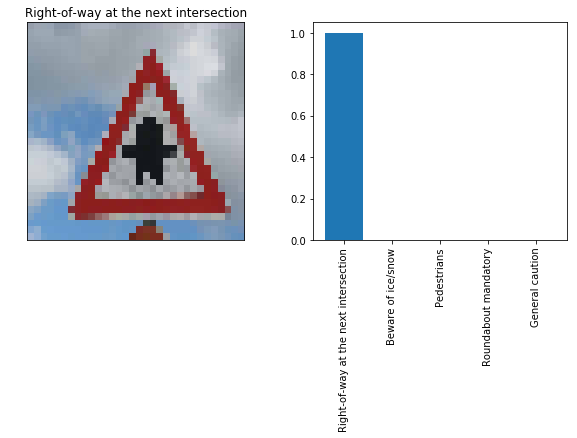

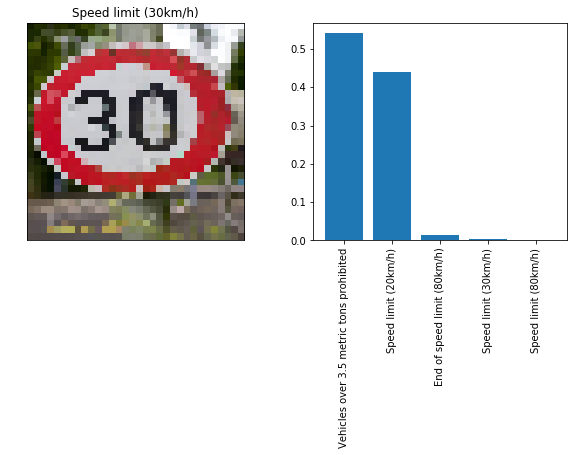

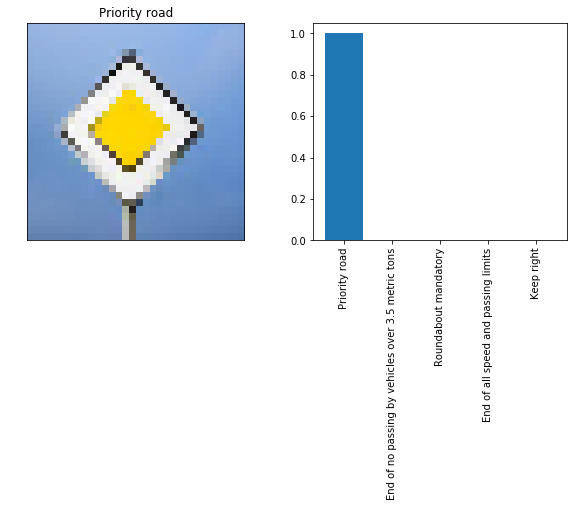

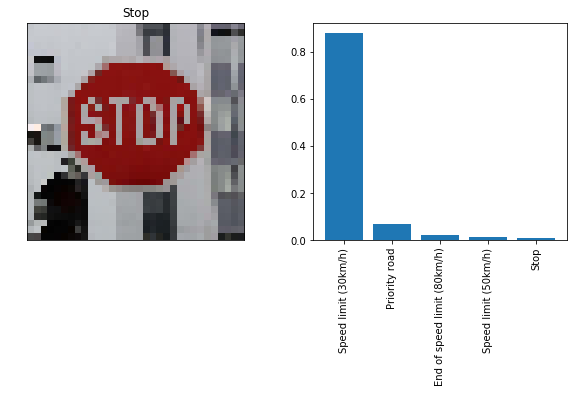

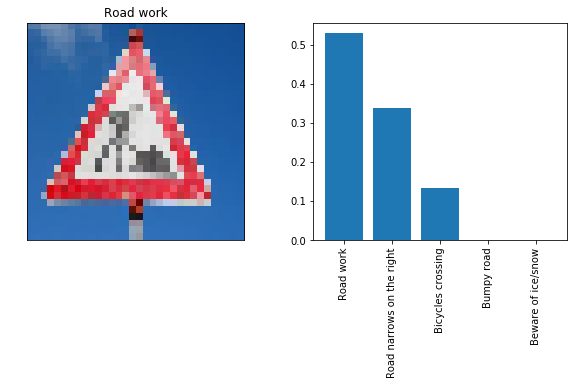

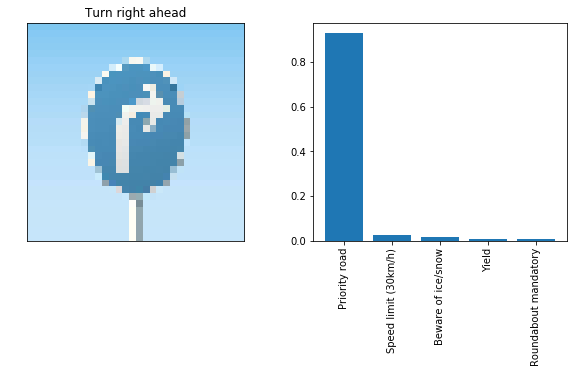

In [54]:
for i, img in enumerate(new_images):
    plt.figure(figsize=(10,4))
    
    plt.subplot(121)
    plt.title(sign_dict[new_labels[i]])
    plt.tick_params(axis='x', colors=(0,0,0,0))
    plt.tick_params(axis='y', colors=(0,0,0,0))
    plt.imshow(new_images[i])

    plt.subplot(122)
    top5_df = pd.DataFrame({"ClassId":top_K_indices[i], "Labels":top_K_labels[i], "Probs":top_K_values[i]})
    
    plt.bar(range(len(top5_df['ClassId'])), top5_df["Probs"])
    plt.xticks(range(len(top5_df['ClassId'])), list(top5_df['Labels']), rotation = 90)
    plt.savefig(os.path.join(new_images_path,  'class_prob' + str(i) + '.png'))
    plt.show()

We are doing pretty well on all signs except the speed limit signs (which can be understood since they are very similar) and the stop sign (this one is more difficult to explain). A more thorough of the hidden layers outputs could help us understand this unexpected result.